# Watermarking for AI-Generated Images

Besides passive detection techniques, providers of generative AI like Google and Meta employ watermarking to help detect their generated content.

The most straight forward way to do this, is to generate content and then add an invisible signal made out of very subtle pixel perturbations and have a detector with is very sensitive to this signal. This is called post-hoc watermarking.

In this assignment, we will take a closer look at such watermarking techniques.

**Note:** If your local setup does not have a GPU, it is highly recommended to run this notebook on Google Colab (see this repository's README for instructions).

In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    os.system('pip install opencv-python')
    os.system('pip install invisible-watermark --no-deps')

In [2]:
import typing
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from diffusers import AutoPipelineForText2Image
from diffusers.utils import make_image_grid, pt_to_pil
from PIL import Image, ImageFilter
from torchvision.transforms.functional import to_tensor
import cv2

from IPython.display import display
from imwatermark import WatermarkEncoder, WatermarkDecoder

# TODO
# torchvision
# diffusers
# opencv-python
# invisible-watermark

## Generating Images Using Stable Diffusion XL Turbo

To demonstrate watermarking techniques for generated images, we will first generate an image.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

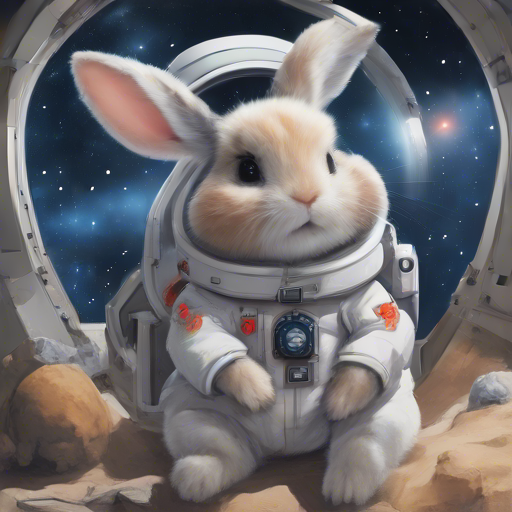

In [3]:
# load model
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
)

if torch.cuda.is_available():

    # performance tweaks
    if torch.cuda.is_available():
        pipeline.enable_sequential_cpu_offload()
    pipeline.upcast_vae()

    # generate
    prompt = "cute rabbit in a spacesuit"  # Your prompt here
    img = pipeline(prompt=prompt, guidance_scale=0.0, num_inference_steps=1).images[0]

# if we are GPU poor, we load download an image instead
else:
    os.system("wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Buwm_O774OieAbrPchfLrf7qNOgNE26C' -O rabbit.png")
    img = Image.open("rabbit.png")

img

# Apply a Simple Watermark to a Generated Image

We now apply a DWT–DCT–SVD Watermark to the image. This scheme can encode bits of information. In out case, this is just a random bit sequence. The following cells contain everything you need to embed this watermark.

You can read more about how these kind of watermarks work here, but it is not necessary for completing the tutorial:
https://github.com/arooshiverma/Image-Watermarking-using-DCT?utm_source=chatgpt.com

In [4]:
# Watermark bits (32 bits from original constant)
WATERMARK_MESSAGE = '1001010010011110011010011010100111101010000111000101010101000101'  # 64 bits
WATERMARKING_SCHEME = 'dwtDctSvd'  # "dwtDct"

def apply_watermark(cover_img: Image,
                    watermark_message: str,
                    method: str = WATERMARKING_SCHEME) -> Image:
    """
    This function applies a simple watermark to the cover image.

    @param cover_img: PIL.Image, the image to which the watermark will be applied
    @param watermark_bits: str, the bits to be encoded in the image
    @param method: str, the watermarking method to use
    @return: PIL.Image, the watermarked image
    """

    # Convert cover image from PIL.Image to cv2, because the encoder expects BGR
    bgr = cv2.cvtColor(np.array(cover_img), cv2.COLOR_RGB2BGR)

    # encode bits to cover image
    encoder = WatermarkEncoder()
    encoder.set_watermark('bits', watermark_message.encode('utf-8'))
    bgr_encoded = encoder.encode(bgr, method)

    # bgr_encoded to PIL
    rgb_encoded = cv2.cvtColor(bgr_encoded, cv2.COLOR_BGR2RGB)
    watermarked_img = Image.fromarray(rgb_encoded)

    return watermarked_img

We will now use the above code to apply a watermark to img and show the result.

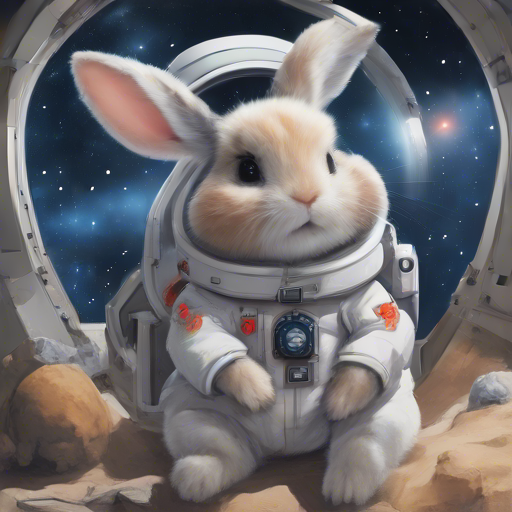

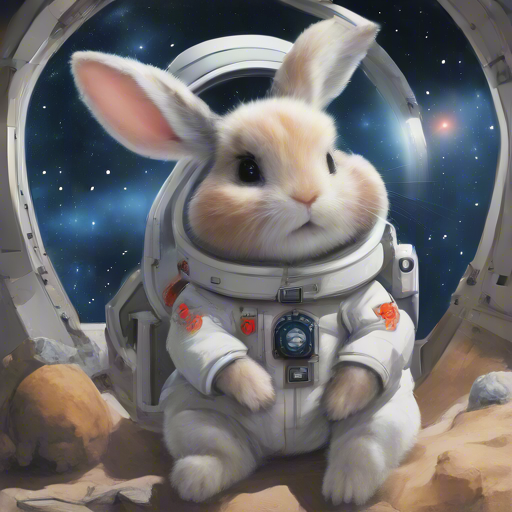

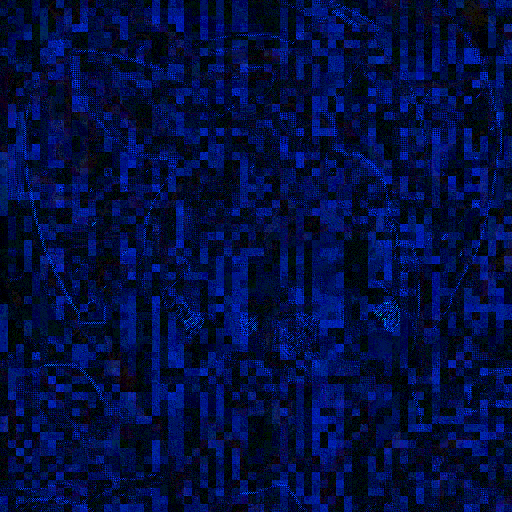

In [5]:
watermarked_img = apply_watermark(img, WATERMARK_MESSAGE)

def difference_magnified(img1: Image, img2: Image, factor=20) -> Image:
    # get the absolute difference in pixel values between both images
    difference = np.array(img1).astype(np.int32) - np.array(img2).astype(np.int32)
    # absolute, do not care if negative or positive
    difference = np.abs(difference)
    # magnify the difference by factor
    magnified = difference * factor
    # clip to fit into pixel range [0, 255]
    magnified = np.clip(magnified, 0, 255)
    # set correct datatype
    magnified = magnified.astype(np.uint8)
    # to PIL Image
    magnified = Image.fromarray(magnified)
    return magnified

display(img,
        watermarked_img,
        difference_magnified(img, watermarked_img))

# Extracting a Watermark from the Image

We will now extract the watermark. Each watermarking scheme provides a detector which is sensitive to the embedded watermark singal. With multi-bit watermarks like DWT-DCT-SVD, this involves extracting the encoded bits from the image.

In [6]:
def decode_watermark_message(watermarked_img: Image,
                             watermark_message_length: int = len(WATERMARK_MESSAGE),
                             method: str = WATERMARKING_SCHEME) -> str:
    """
    This function extracts a watermark from a watermarked image.

    @param watermarked_img: PIL.Image, the image from which the watermark will be extracted
    @param watermark_message_length: int, the length of the watermark message
    @param method: str, the watermarking method to use
    @return: the extracted watermark bits (str)
    """

    # Convert to OpenCV BGR
    bgr = cv2.cvtColor(np.array(watermarked_img), cv2.COLOR_RGB2BGR)

    # Decode watermark
    decoder = WatermarkDecoder('bits', watermark_message_length)
    decoded_bits = decoder.decode(bgr, method)

    # Convert both to bit strings
    decoded_message = ''.join(f'{b:1b}' for b in decoded_bits)

    return decoded_message

In [7]:
decoded_message = decode_watermark_message(watermarked_img)
print('decoded :', decoded_message)
print('original:', WATERMARK_MESSAGE)

decoded : 1001010010011110011010011010100111101010000111000101010101000101
original: 1001010010011110011010011010100111101010000111000101010101000101


# Detecting/Verifying a Watermark from the Extracted Information

If an image has not been not watermarked, we would expect the number of matching bit to be 50% by pure chance. For watermarked images, the number of correct bits is much higher. We can simply set a threshold to decide if an image is watermarked with our WATERMARK_MESSAGE: If the number of correct bits after recovery is bigger than this threshold, we say it watermarked. This threshold can be theoretically calculated by applying the complementary binomial CDF for a specific target of false positives. We will not go into detail and just fix the threshold at 1 in a thousand un-watermarked images will be falsely recognized as watermarked. The corresponding threshold is 37 / 64 = 0.578125.

In [8]:
DETECTION_THRESHOLD = 0.578125

def verify_watermark(original_message: str,
                     decoded_message: str) -> typing.Union[float, bool]:
    """
    Verify/detect the watermark by comparing matches and
    checking against the detection threshold.

    @param original_message: str, the original message
    @param decoded_message: str, the decoded message
    @return: matching_bits_ratio (int), verify_successful (bool)
    """

    assert len(original_message) == len(decoded_message)

    matches = sum(a == b for a, b in zip(original_message, decoded_message))
    matching_bits_ratio = matches / len(original_message)

    return matching_bits_ratio, matching_bits_ratio > DETECTION_THRESHOLD

In [9]:
matching_bits_ratio, detection_success = verify_watermark(WATERMARK_MESSAGE, decoded_message)
print('the image is',
      'watermarked' if detection_success else "not watermarked",
      'because the ratio of matching bits',
      matching_bits_ratio,
      'is',
      'bigger than' if detection_success else 'smaller or equal to',
      'the detection threshold',
      DETECTION_THRESHOLD)

the image is watermarked because the ratio of matching bits 1.0 is bigger than the detection threshold 0.578125


# Watermark Robustness

Watermarks should be robust against transformations. Ideally, an tampering with the image that is able to remove the watermark should also destroy the image content. Here are some transformation functions.

In [10]:
def rotate(img: Image, degrees: int) -> Image:
    """
    @param img: PIL.Image, the image to be rotated
    @param degrees: int, the degrees to rotate the image
    @return: PIL.Image, the rotated image
    """
    return transforms.RandomRotation((degrees, degrees))(img)

def crop_scale(img: Image, ratio: int) -> Image:
    """
    @param img: PIL.Image, the image to be cropped
    @param ratio: int, the ratio to crop the image
    @return: PIL.Image, the cropped image
    """
    return transforms.RandomResizedCrop(img.size,
                                        scale=(ratio, ratio),
                                        ratio=(1, 1))(img)

def random_crop(img: Image, ratio: int) -> Image:
    """
    @param img: PIL.Image, the image to be cropped
    @param ratio: int, the ratio to crop the image
    @return: PIL.Image, the cropped image
    """
    width, height, c = np.array(img).shape
    img = np.array(img)
    new_width = int(width * ratio)
    new_height = int(height * ratio)
    start_x = np.random.randint(0, width - new_width + 1)
    start_y = np.random.randint(0, height - new_height + 1)
    end_x = start_x + new_width
    end_y = start_y + new_height
    padded_image = np.zeros_like(img)
    padded_image[start_y:end_y, start_x:end_x] = img[start_y:end_y, start_x:end_x]
    img = Image.fromarray(padded_image)
    return img

def random_drop(img: Image, ratio: int) -> Image:
    """
    @param img: PIL.Image, the image to be cropped
    @param ratio: int, the ratio to crop the image
    @return: PIL.Image, the cropped image
    """
    width, height, c = np.array(img).shape
    img = np.array(img)
    new_width = int(width * ratio)
    new_height = int(height * ratio)
    start_x = np.random.randint(0, width - new_width + 1)
    start_y = np.random.randint(0, height - new_height + 1)
    padded_image = np.zeros_like(img[start_y:start_y + new_height, start_x:start_x + new_width])
    img[start_y:start_y + new_height, start_x:start_x + new_width] = padded_image
    img = Image.fromarray(img)
    return img

def median_blur_k(img: Image, radius: int) -> Image:
    """
    @param img: PIL.Image, the image to be blurred
    @param radius: int, the radius of the blur
    @return: PIL.Image, the blurred image
    """
    return img.filter(ImageFilter.MedianFilter(radius))

def gaussian_blur(img: Image, radius: int) -> Image:
    """
    @param img: PIL.Image, the image to be blurred
    @param radius: int, the radius of the blur
    @return: PIL.Image, the blurred image
    """
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

def gaussian_std(img: Image, std: int) -> Image:
    """
    @param img: PIL.Image, the image to be blurred
    @param std: int, the std of the blur
    @return: PIL.Image, the blurred image
    """
    img_tensor = transforms.ToTensor()(img)
    g_noise = torch.randn_like(img_tensor) * std
    noisy_img_tensor = torch.clamp(img_tensor + g_noise, 0, 1)
    img = transforms.ToPILImage()(noisy_img_tensor)
    return img

def brightness_factor(img: Image, factor: int) -> Image:
    """
    @param img: PIL.Image, the image to be brightened
    @param factor: int, the factor to brighten the image
    @return: PIL.Image, the brightened image
    """
    return transforms.ColorJitter(brightness=factor)(img)

def resize(img: Image, ratio: int) -> Image:
    """
    @param img: PIL.Image, the image to be resized
    @param ratio: int, the ratio to resize the image
    @return: PIL.Image, the resized image
    """
    img_shape = np.array(img).shape
    resize_size = int(img_shape[0] * ratio)
    img = transforms.Resize(size=resize_size)(img)
    img = transforms.Resize(size=img_shape[0])(img)
    return img

Let's apply the transformations and see what they do to the watermark

rotate (75): matching bit ratio: 0.515625, detection success: False


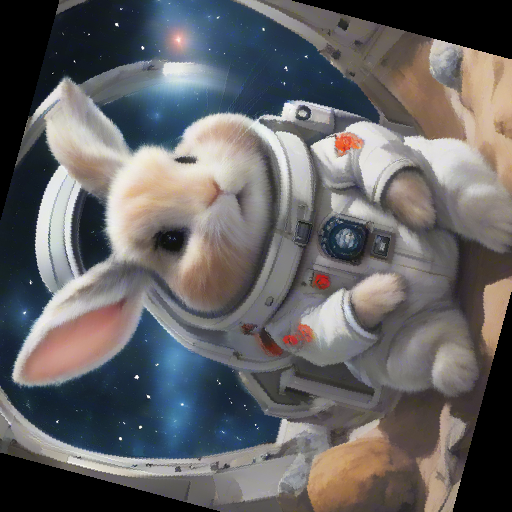

crop_scale (0.95): matching bit ratio: 0.640625, detection success: True


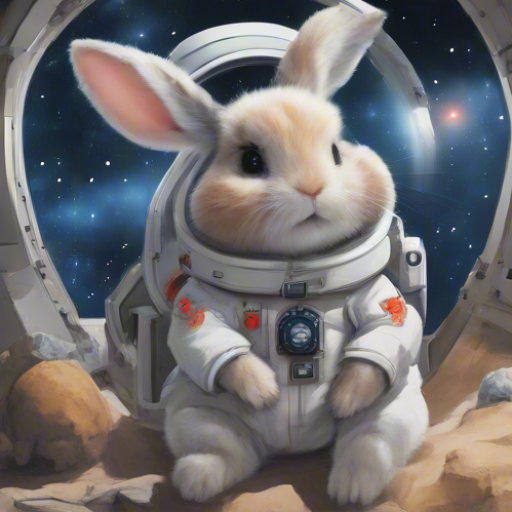

random_crop (0.6): matching bit ratio: 0.828125, detection success: True


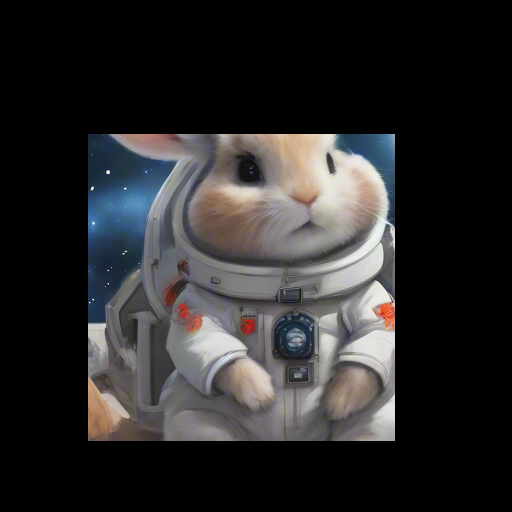

random_drop (0.6): matching bit ratio: 0.71875, detection success: True


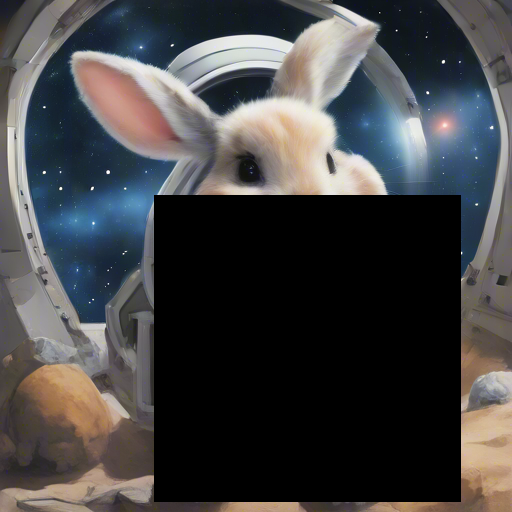

median_blur_k (5): matching bit ratio: 1.0, detection success: True


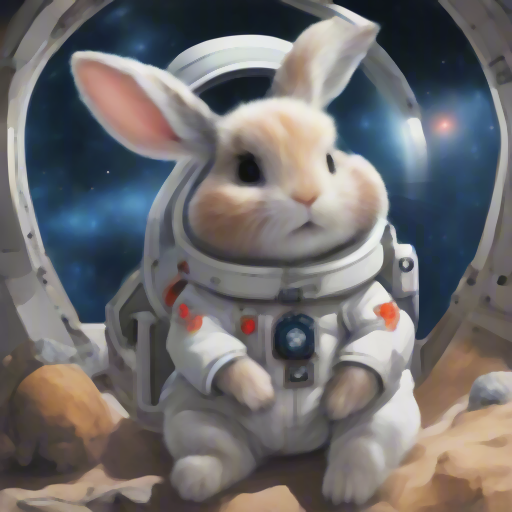

gaussian_blur (5): matching bit ratio: 0.6875, detection success: True


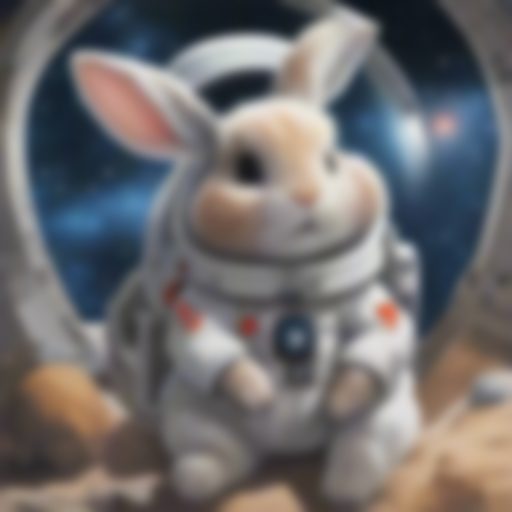

gaussian_std (0.1): matching bit ratio: 0.59375, detection success: True


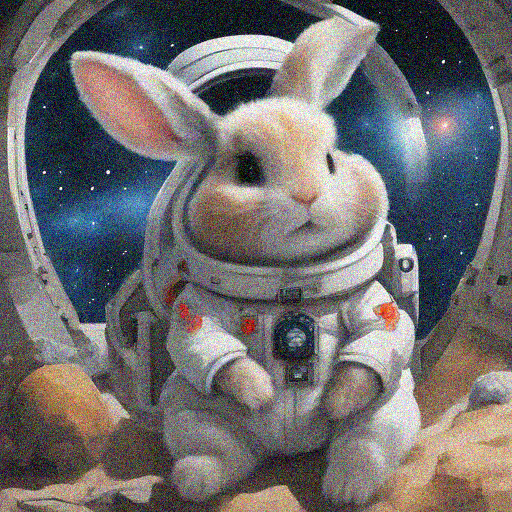

brightness_factor (6): matching bit ratio: 0.515625, detection success: False


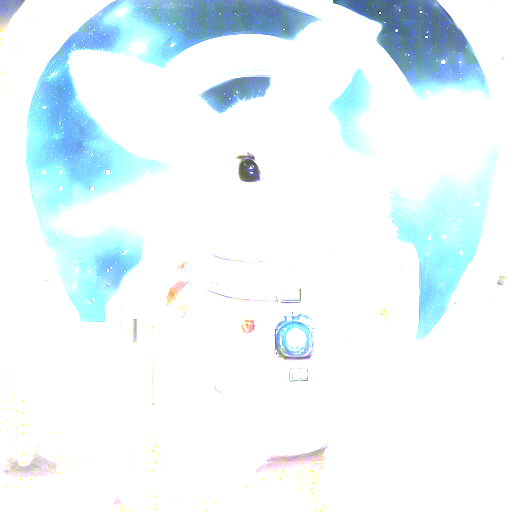

resize (0.2): matching bit ratio: 0.796875, detection success: True


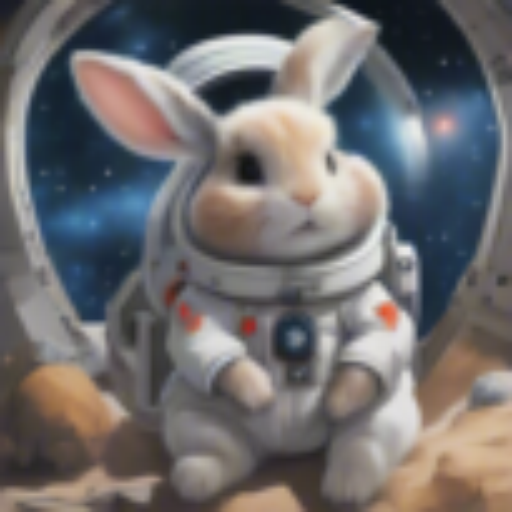

In [11]:
TRANSFORMATIONS = [rotate, crop_scale, random_crop, random_drop, median_blur_k, gaussian_blur, gaussian_std, brightness_factor, resize]
VALUES          = [75,     0.95,       0.6,         0.6,         5,             5,             0.1,          6,                 0.2]

# transform the watermarked image
def yield_transformation(img_to_be_transformed: Image):
    for transformation, value in zip(TRANSFORMATIONS,
                                     VALUES):
        yield transformation(img_to_be_transformed, value)
transformed_images = list(yield_transformation(watermarked_img))

# verify the watermark in each image
def yield_detection_metrics(images: typing.List[Image]):
    for img in images:
        decoded_message = decode_watermark_message(img)
        matching_bit_ratio, detection_success = verify_watermark(WATERMARK_MESSAGE, decoded_message)
        yield matching_bit_ratio, detection_success
matching_bit_ratios, detection_successes = zip(*list(yield_detection_metrics(transformed_images)))

# display
for transformation, value, transformed_img, matching_bit_ratio, detection_success in zip(TRANSFORMATIONS, VALUES, transformed_images, matching_bit_ratios, detection_successes):
    print(f"{transformation.__name__} ({value}): matching bit ratio: {matching_bit_ratio}, detection success: {detection_success}")
    display(transformed_img)

You can also chain tranformations.

matching bit ratio: 0.578125, detection success: False


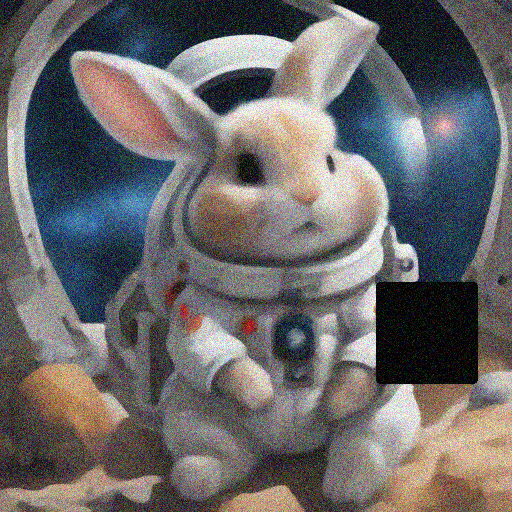

In [12]:
transformed_image = gaussian_std(
    median_blur_k(
        random_drop(
            watermarked_img,
            0.2),
        7),
    0.1)

decoded_message = decode_watermark_message(transformed_image)
matching_bit_ratio, detection_success = verify_watermark(WATERMARK_MESSAGE, decoded_message)

print(f"matching bit ratio: {matching_bit_ratio}, detection success: {detection_success}")
display(transformed_image)

# Evaluating Robustness with Quality Metrics

When performing watermark removal as an adversary, the goal is to remove the watermark while preserving as much of the original iamge as possible by some metric. One such metric is the peak signal-to-noise ratio (https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio), PSNR in short. We caluclate the PSNR for all the transformations from before

In [13]:
def compute_psnr(img1: Image, img2: Image) -> float:
    """
    Compute the peak signal-to-noise ratio (PSNR) between two images.

    @param img1: PIL.Image, the first image
    @param img2: PIL.Image, the second image
    @return: float, the PSNR value
    """

    img1 = np.array(img1).astype(np.float64) / 255.0
    img2 = np.array(img2).astype(np.float64) / 255.0
    # The PSNR is bascially just MSE measures in decibels
    mse = np.mean((img1 - img2) ** 2)
    # PSNR for perfectly matching images is infinity. We just set some high value instead
    if mse == 0:
        return 60
    max_pixel = 1.0  # Max pixel value after normalization
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


# calculate the PSNR betweent he original watermarked image and its transfomrations
psnr_values = []
for transformation, value, transformed_img, matching_bit_ratio, detection_success in zip(TRANSFORMATIONS, VALUES, transformed_images, matching_bit_ratios, detection_successes):
    # compute the PSNR between transformed_img and watermarked_img
    psnr = compute_psnr(watermarked_img, transformed_img)
    psnr_values.append(psnr)

We can plot the resulting trade-off between image quality and watermark removal success like this:

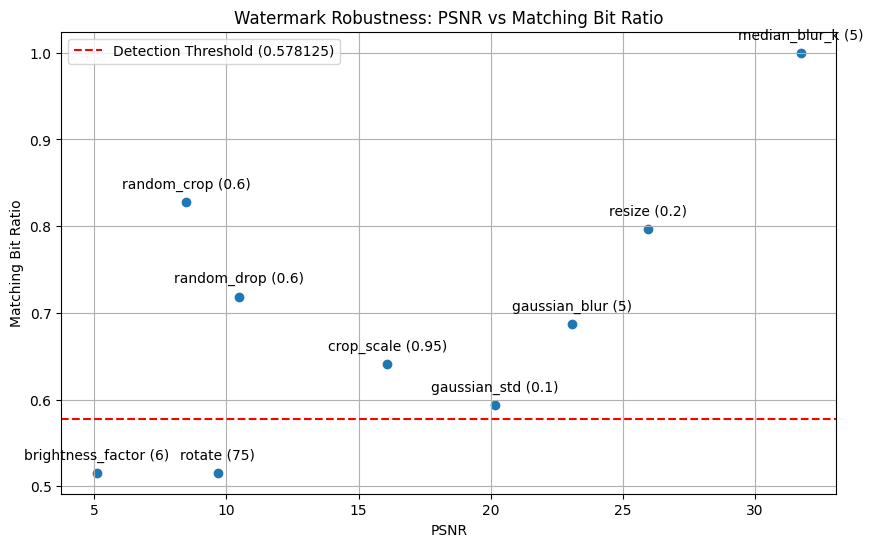

In [14]:
def plot_robustness(transformation_names: typing.List[str],
                    matching_bit_ratios: typing.List[float],
                    psnr_values: typing.List[float],
                    filename: str = None):
    """
    Plots the watermark robustness based on PSNR and matching bit ratios.

    @param psnr_values: list, the PSNR values for each transformation
    @param transformation_names: list, names of the transformations applied (as strings)
    @param matching_bit_ratios: list, the matching bit ratios for each transformation
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(psnr_values, matching_bit_ratios)

    # annotate each point
    for i, name in enumerate(transformation_names):
        plt.annotate(name, (psnr_values[i], matching_bit_ratios[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # plot the detection threshold
    plt.axhline(y=DETECTION_THRESHOLD, color='r', linestyle='--', label=f'Detection Threshold ({DETECTION_THRESHOLD})')
    plt.legend()

    # finalize the plot
    plt.xlabel('PSNR')
    plt.ylabel('Matching Bit Ratio')
    plt.title('Watermark Robustness: PSNR vs Matching Bit Ratio')
    plt.grid(True)
    plt.show()

    if filename is not None:
        plt.savefig(filename)

# plot
transformation_names = [f"{t.__name__} ({v})" for t, v in zip(TRANSFORMATIONS, VALUES)]
plot_robustness(transformation_names, matching_bit_ratios, psnr_values)

# Watermark Removal Challenge

Now it is your turn. Try to remove the watermor form the image while keeping PSNR above 25. Plot the result. You may need to invent your own transformations.
Good luck!

Matching bit ratio: 1.0, psnr: 9.66163725372306


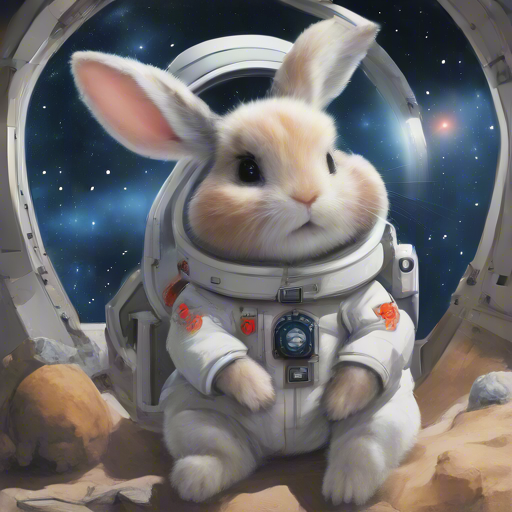

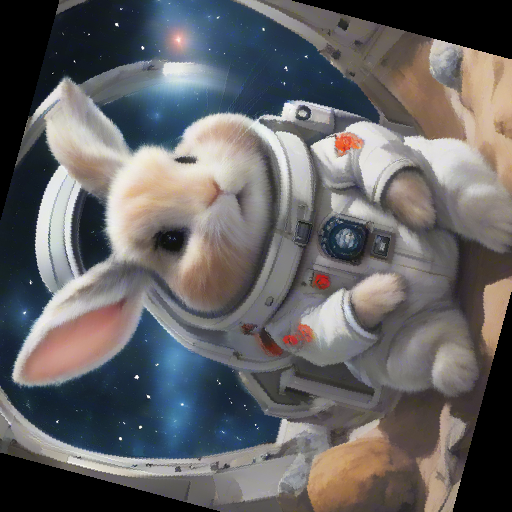

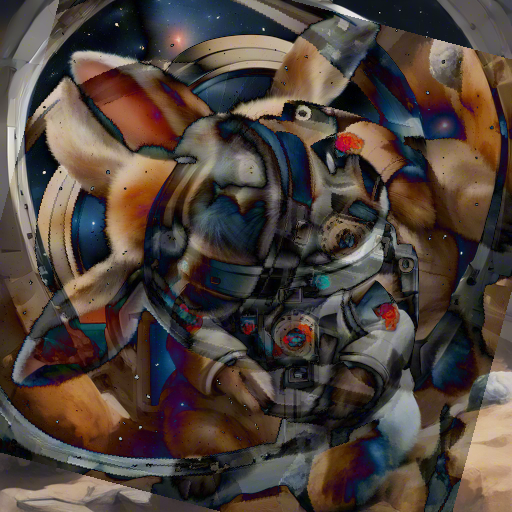

In [15]:
# When you are ready, just put the resulting image into this function
# and show us the result
def check_result(watermarked_img: Image, cleaned_img: Image):
    """
    @param watermarked_img: PIL.Image, the watermarked image
    @param cleaned_img: PIL.Image, the cleaned image
    """
    decoded_message = decode_watermark_message(watermarked_img)
    matching_bits_ratio, detection_success = verify_watermark(WATERMARK_MESSAGE,
                                                              decoded_message)
    psnr = compute_psnr(watermarked_img, cleaned_img)

    print(f"Matching bit ratio: {matching_bits_ratio}, psnr: {psnr}")
    display(watermarked_img, cleaned_img, difference_magnified(watermarked_img,
                                                               cleaned_img,
                                                               factor=1))

check_result(watermarked_img,
             transformed_images[0]  # dummy image
             )

In [ ]:
vae = pipeline.vae.eval()

# Preprocess input image (PIL to tensor in [-1, 1])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])
image_tensor = preprocess(watermarked_img).unsqueeze(0)

if torch.cuda.is_available():
    vae = vae.to("cuda")
    image_tensor = image_tensor.to("cuda")

# Encode & Decode with VAE
with torch.no_grad():
    latents = vae.encode(image_tensor.half()).latent_dist.sample() * 0.18215  # SDXL latent scale
    recon = vae.decode(latents).sample

# Convert back to PIL
recon = (recon.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
recon_pil = transforms.ToPILImage()(recon.squeeze().cpu())
recon_pil